In [ ]:
import pandas as pd
from sklearn_extra.cluster import KMedoids
from Bio import AlignIO
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import re
import ete3
import numpy as np
from scipy.stats import chisquare
import phylo_msa as pm
import os



pattern_taxa = r"OS=([^=]+?)\sOX="
mammals_tree = ete3.Tree("data/mammalia.tre", format=1)
species_in_msa = pd.read_csv("results/species_in_all_msa.csv", index_col=0)
all_species = [sp.replace(" ","_") for sp in list(species_in_msa.index)]

# Get common species
common_species = pd.read_csv("data/common_species.csv")
common_species['scientific name'] = [sp.replace(" ", "_") for sp in common_species['scientific name']]

## **From a conserved protein sequences**
### **KMedoids on IPRB**

From the interphotoreceptor retinoid-binding protein (IPRB), a commonly used genes in phylogenetic trees reconstruction, we created a ML-tree with Iqtree2.  
The inferred distances between species sequences is then used for clustering and KMedoids are determined from it.

In [ ]:
# Perform KMedoids clustering on IPRB proteins sequences
# Extract MSA of P10475
msa = AlignIO.read("data/deduplicate_msas/P10745", format="fasta")
msa_records = {record.id: re.search(pattern_taxa, record.description).group(1) for record in msa}

# Extract distance from ML phylogenetic tree based on IPRB sequences alignment
dist_mat = pd.read_csv("data/P10745.mldist", skiprows=1, delim_whitespace=True, index_col=0, header=None)
dist_mat.columns = dist_mat.index
distance_matrix = dist_mat.values

# Apply k-medoids
k = 248  # for example
kmedoids = KMedoids(n_clusters=k, metric="precomputed", random_state=992801).fit(distance_matrix)
medoids = list(dist_mat.index[kmedoids.medoid_indices_])

cluster_labels = kmedoids.labels_
medoid_indices = kmedoids.medoid_indices_

medoids_species = [msa_records[medoid].replace(" ", "_") for medoid in medoids]
medoids_species

# Apply t-SNE to the pairwise distance matrix
tsne = TSNE(n_components=2, metric="precomputed", random_state=30, init='random')
tsne_coords = tsne.fit_transform(distance_matrix)

plt.figure(figsize=(10, 8))

# Plot all points colored by cluster
for cluster_id in range(k):
    cluster_points = tsne_coords[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=20)

# Highlight medoids
plt.scatter(tsne_coords[medoid_indices, 0], tsne_coords[medoid_indices, 1], 
            color='black', marker='*', s=200, label='Medoids')
# Customize the plot
plt.title("t-SNE visualization of IPRB MSA medoids")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.tight_layout()
plt.show()

['tr|A0A2P1C9T2|A0A2P1C9T2_9MURI', 'tr|I3PFS7|I3PFS7_9MURI', 'tr|A0A8A1UBG6|A0A8A1UBG6_9MURI', 'tr|E0A0T6|E0A0T6_9MURI', 'tr|A0A1I9KE79|A0A1I9KE79_9RODE']


## **From a phylogenetic mammalia tree**

### **Topological Tree (4,041/5,437)**

In [85]:
# identify species that are note in the tree
mammalia_leafs = [leaf.name for leaf in mammals_tree]

absent_species = set(all_species) - set(mammalia_leafs)
print(f"{len(absent_species)}/{len(all_species)} species are absent of the mammalia tree.")

all_species_cleaned = set(all_species) - absent_species

# Re-write the mammalia tree only with MSA-present species
mammals_tree_pruned = ete3.Tree("data/mammalia.tre", format=1)
mammals_tree_pruned.prune(all_species_cleaned, preserve_branch_length=True)
mammals_tree_pruned.write(outfile="data/mammalia_pruned.nw", format=8)

1396/5437 species are absent of the mammalia tree.


In [ ]:
species = [sp.replace("_", " ") for sp in all_species_cleaned]
species.sort()

Abrawayaomys ruschii
Abrocoma cinerea
Abrothrix andinus polius
Abrothrix illuteus
Abrothrix jelskii inambarii
Abrothrix lanosus
Abrothrix longipilis moerens
Acerodon celebensis
Acerodon jubatus
Acinonyx jubatus
Acomys cahirinus
Acomys cf. cineraceus
Acomys cf. cineraceus KE709
Acomys cf. cineraceus KE734
Acomys cf. kempi ETH0332
Acomys cf. kempi ETH0390
Acomys cf. kempi KE824
Acomys cf. kempi KE883
Acomys cf. mullah ET168
Acomys cf. mullah ETH0033
Acomys cf. mullah ETH0060
Acomys cf. wilsoni E030
Acomys cf. wilsoni E042
Acomys chudeaui
Acomys dimidiatus
Acomys ignitus
Acomys johannis
Acomys louisae
Acomys muzei
Acomys ngurui
Acomys percivali
Acomys russatus russatus
Acomys spinosissimus
Acomys subspinosus
Acomys wilsoni
Aconaemys fuscus
Aconaemys porteri
Aconaemys sagei
Acrobates pygmaeus
Addax nasomaculatus
Aegialomys galapagoensis
Aegialomys xanthaeolus
Aeorestes cinereus cinereus
Aeorestes egregius
Aeorestes semotus
Aeorestes villosissimus
Aepeomys lugens
Aepyceros melampus petersi


In [28]:
with open("data/vertlife_mammalia.txt", "r") as vert_life:
    vert_life_mammals = []
    for line in vert_life:
        vert_life_mammals.append(line.strip())

In [43]:
all_species_form = [sp.replace("_", " ") for sp in all_species]
rest = set(all_species_form) - set(vert_life_mammals)
rest = set(all_species_form) - rest
rest = list(rest)
rest.sort()
len(rest)

with open("results/vert_life_mammals.txt","w+") as f:
    for sp in rest:
        f.write(f"{sp.strip()}\n")

In [52]:
trees_newick = []
with open("results/vert_life/output.nex", "r") as f:
    tree = False
    count = 0
    for line in f:
        count += 1
        if tree == True:
            if line.startswith("END"):
                break
            trees_newick.append(line.split("=")[1].strip())
        if line.startswith("BEGIN"):
            tree = True
            continue

In [59]:
count = 1
for tree in trees_newick:
    with open(f"data/vert_life/tree_{count}.nw", "w+") as newick_file:
        newick_file.write(tree)
    count += 1

['Homo sapiens',
 'Pan troglodytes',
 'Pan paniscus',
 'Gorilla gorilla gorilla',
 'Pongo abelii',
 'Mandrillus leucophaeus',
 'Macaca fascicularis',
 'Macaca mulatta',
 'Macaca nemestrina',
 'Cercocebus atys',
 'Papio anubis',
 'Chlorocebus sabaeus',
 'Colobus angolensis palliatus',
 'Rhinopithecus roxellana',
 'Piliocolobus tephrosceles',
 'Aotus nancymaae',
 'Callithrix jacchus',
 'Cebus imitator',
 'Nomascus leucogenys',
 'Sapajus apella',
 'Saimiri boliviensis boliviensis',
 'Prolemur simus',
 'Otolemur garnettii',
 'Vicugna pacos',
 'Propithecus coquereli',
 'Urocitellus parryii',
 'Camelus ferus',
 'Camelus bactrianus',
 'Marmota monax',
 'Camelus dromedarius',
 'Odobenus rosmarus divergens',
 'Zalophus californianus',
 'Capra hircus',
 'Neomonachus schauinslandi',
 'Callorhinus ursinus',
 'Sciurus vulgaris',
 'Ursus maritimus',
 'Panthera leo',
 'Leptonychotes weddellii',
 'Muntiacus reevesi',
 'Ailuropoda melanoleuca',
 'Sciurus carolinensis',
 'Panthera pardus',
 'Rhinolophus

### **Upham *et al.* Mammals phylogenetic tree ([doi](https://doi.org/10.1371/journal.pbio.3000494])) (3,186/5,437)**

#### **Data Prep.**

In [123]:
upham_mam_tree = ete3.Tree("data/RAxML_bipartitions.mammalia.newick", format = 1)
for leave in upham_mam_tree.get_leaves():
    leave.name = "_".join(leave.name.split("_")[0:2])

upham_mam_tree.write(outfile="results/upham_et_al/upham_tree_cleaned.nw", format=0)

upham_mam_species = [leaf.name for leaf in upham_mam_tree.get_leaves()]

present_species = set(all_species) - (set(all_species) - set(upham_mam_species))

print(f"{len(present_species)}/{len(all_species)} species are in Uphan et al. mammalia tree.")

upham_mam_tree.prune(present_species)
upham_mam_tree.write(outfile="results/upham_et_al/upham_tree.nw", format=0)

print(upham_mam_tree)

3186/5437 species are in Uphan et al. mammalia tree.

                                                /-Dinomys_branickii
                                               |
                                               |         /-Chinchilla_chinchilla
                                             /-|      /-|
                                            |  |   /-|   \-Chinchilla_lanigera
                                            |  |  |  |
                                            |   \-|   \-Lagidium_viscacia
                                            |     |
                                            |      \-Lagostomus_maximus
                                            |
                                            |               /-Octomys_mimax
                                            |            /-|
                                            |           |  |   /-Pipanacoctomys_aureus
                                            |           |   \-|
                        

In [91]:
# Extract species in the prunned tree, for 256 remaining leaves

# Check if all common species are in the Upham et al. tree and in the MSAs
for sp in common_species['scientific name']:
    all_good = True
    if (sp in present_species): continue
    elif sp in upham_mam_species: print(f"{sp} appears in Upham et al. tree but not in MSAs.")
    elif sp in all_species: print(f"{sp} appears in MSAs but not in Upham et al. tree.")
    else: 
        print(f"{sp} does not appears in data.")
        all_good = False
if all_good:
    print("All common species appears in Upham et al. tree and in MSAs")

All common species appears in Upham et al. tree and in MSAs


In [138]:
# Check that selected species are well distributed across all MSAs

# Get all species that appear in MSA
binary_species_in_msa = (species_in_msa > 0).astype(int)
distribution_species = binary_species_in_msa.apply(sum, axis=1)
distribution_species.index = [sp.replace(" ", "_") for sp in distribution_species.index]
distribution_species = distribution_species.sort_values(ascending=False)
# Get species that are also present in Upham et al. tree
distribution_present_species = distribution_species[list(present_species)]
distribution_present_species = distribution_present_species.sort_values(ascending=False)

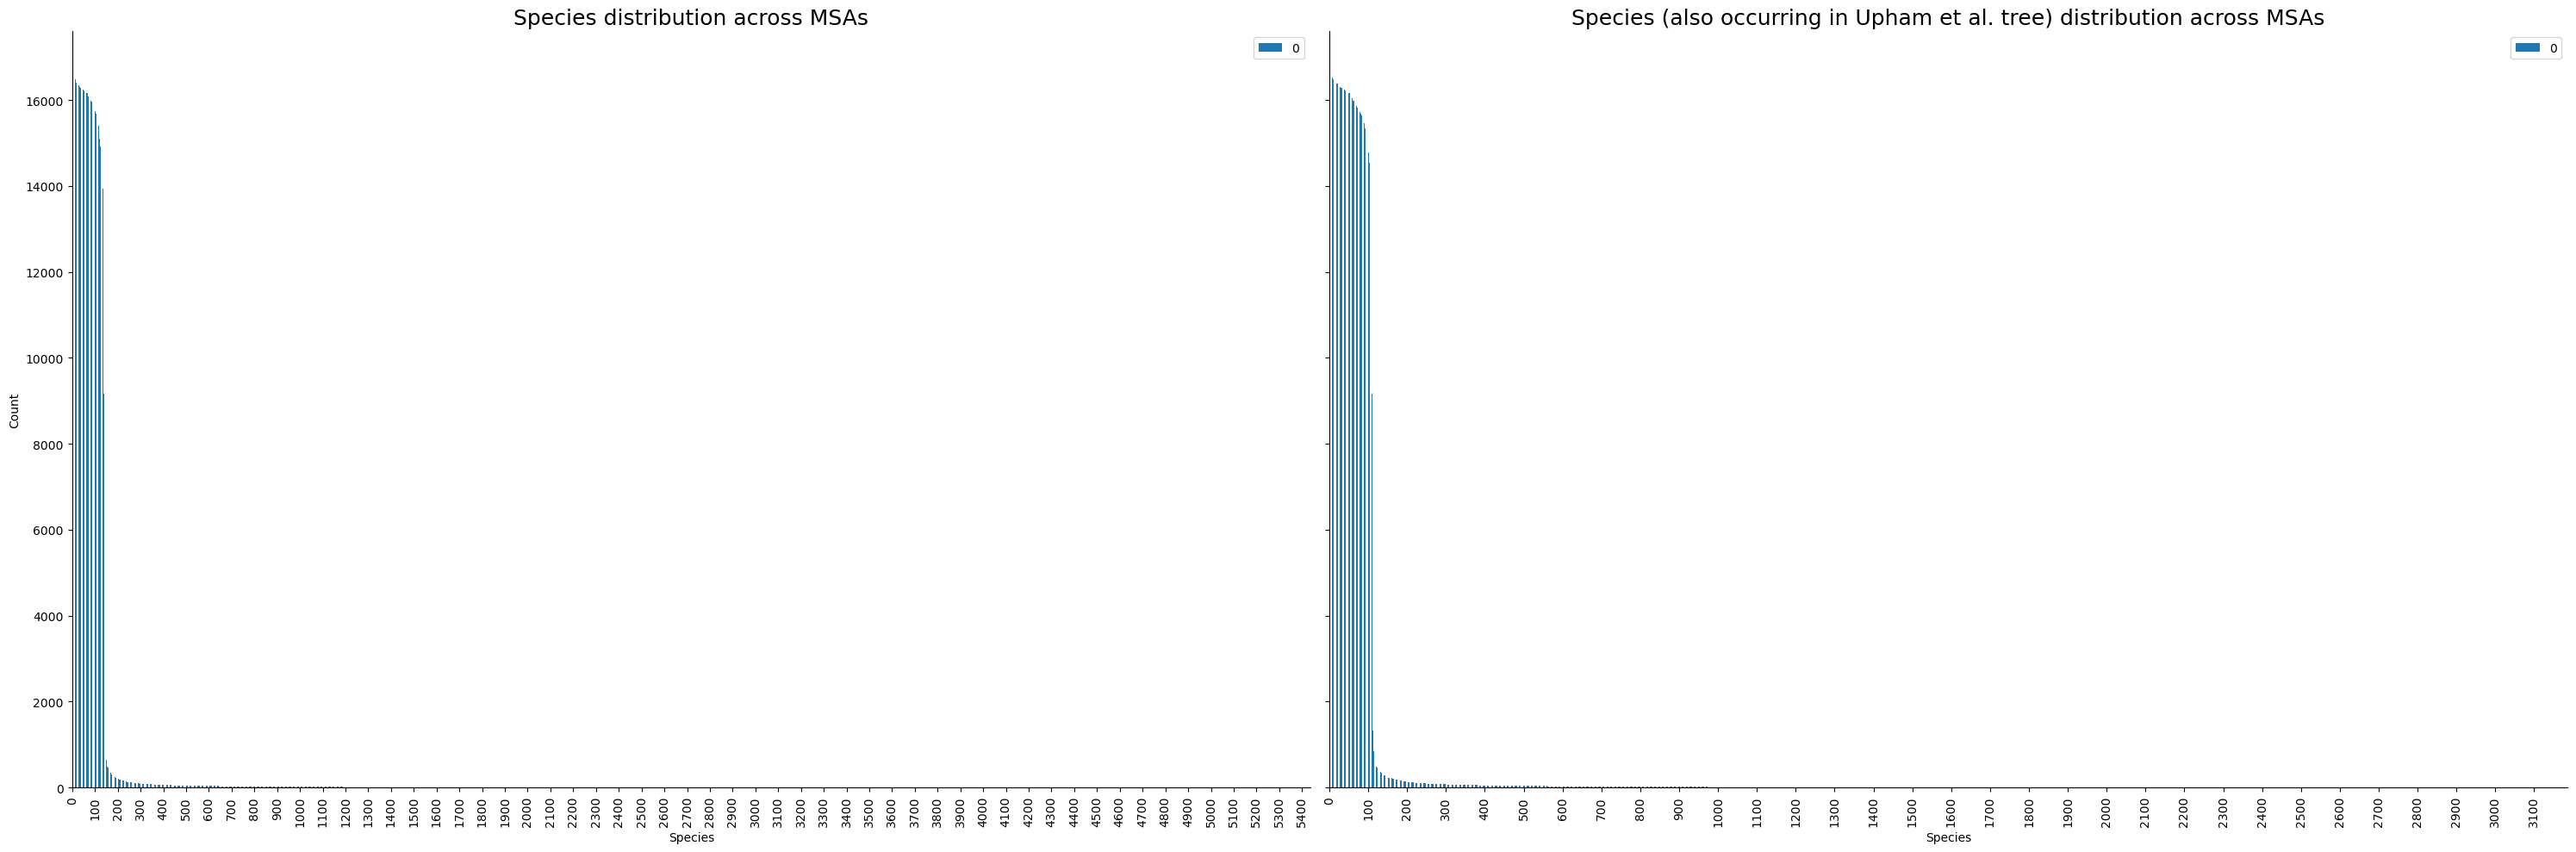

In [121]:
distribution_species_ni = distribution_species.reset_index()
distribution_present_species_ni = distribution_present_species.reset_index()

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey=True)

# Plot for all species
distribution_species_ni.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel("Species")
axes[0].set_ylabel("Count")
axes[0].set_xticks(np.arange(0, 5450, 100))
axes[0].set_title("Species distribution across MSAs", fontsize=18)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot for species also occurring in Upham et al. tree
distribution_present_species_ni.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel("Species")
axes[1].set_xticks(np.arange(0, 3200, 100))
axes[1].set_title("Species (also occurring in Upham et al. tree) distribution across MSAs", fontsize=18)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Align indices and fill missing species in the subsample with 0
aligned_present = distribution_species.copy()
aligned_present[:] = distribution_present_species.reindex_like(distribution_species).fillna(0)

# Align
dist_full = distribution_species / distribution_species.sum()
dist_sub  = aligned_present / aligned_present.sum()

# Statistic
chi_stat, chi_p = chisquare(f_obs=dist_sub.values, f_exp=dist_full.values)
print(f"Chi-squared statistic: {chi_stat}, p-value: {chi_p}")


Chi-squared statistic: 0.26692871346969016, p-value: 1.0


#### **After Treemmer pruning**

In [119]:
# Extract species in the prunned tree, for 256 remaining leaves
species_256 = []
with open("results/upham_et_al/upham_trimmed_list_256.txt", "r") as f:
    for sp in f:
        species_256.append(sp.strip())

print("------256 LEAVES------")
species_256_completed = species_256
absent = []
for sp in common_species['scientific name']:
    if sp not in species_256:
        species_256_completed.append(sp)
        absent.append(sp)
print(f"Absent species: {', '.join(absent)}")

species_512 = []
with open("results/upham_et_al/upham_trimmed_list_512.txt", "r") as f:
    for sp in f:
        species_512.append(sp.strip())

print("------512 LEAVES------")
species_512_completed = species_512
absent = []
for sp in common_species['scientific name']:
    if sp not in species_512:
        species_512_completed.append(sp)
        absent.append(sp)
print(f"Absent species: {', '.join(absent)}")

# Check distribution of selected species
dist_256 = distribution_species[species_256_completed]
dist_512 = distribution_species[species_512_completed]
dist_256.sort_values(ascending=False, inplace=True)
dist_512.sort_values(ascending=False, inplace=True)

dist_512_ni = dist_512.reset_index()
dist_256_ni = dist_256.reset_index()

------256 LEAVES------
Absent species: Mus_musculus, Rattus_norvegicus, Homo_sapiens, Macaca_mulatta, Macaca_fascicularis, Callithrix_jacchus, Cavia_porcellus, Mesocricetus_auratus, Peromyscus_maniculatus, Oryctolagus_cuniculus, Canis_lupus, Felis_catus, Sus_scrofa, Bos_taurus, Ovis_aries, Equus_caballus, Tupaia_belangeri, Chlorocebus_sabaeus
------512 LEAVES------
Absent species: Mus_musculus, Rattus_norvegicus, Homo_sapiens, Macaca_mulatta, Macaca_fascicularis, Callithrix_jacchus, Cavia_porcellus, Mesocricetus_auratus, Peromyscus_maniculatus, Oryctolagus_cuniculus, Canis_lupus, Felis_catus, Sus_scrofa, Bos_taurus, Ovis_aries, Equus_caballus, Chlorocebus_sabaeus


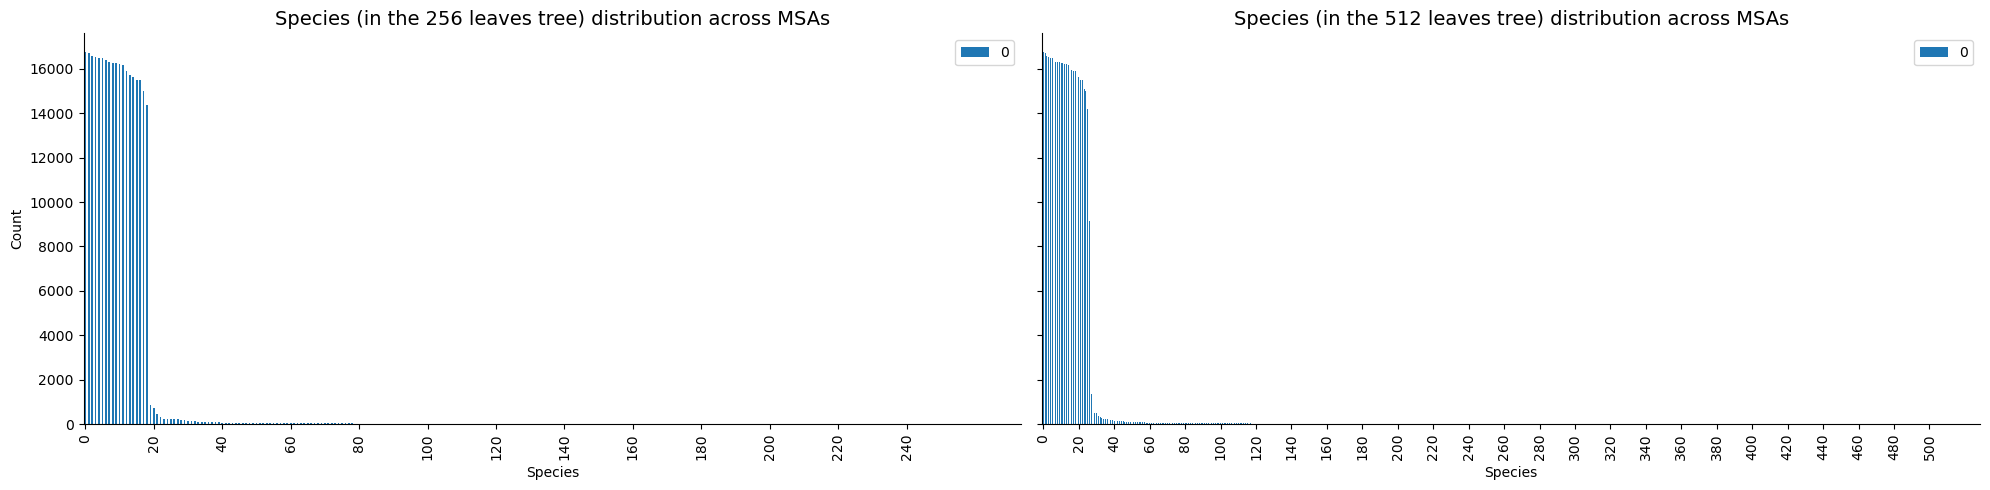

In [120]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

# Plot for 256 leaves
dist_256_ni.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel("Species")
axes[0].set_ylabel("Count")
axes[0].set_xticks(np.arange(0, 256, 20))
axes[0].set_title("Species (in the 256 leaves tree) distribution across MSAs", fontsize=14)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot for 512 leaves
dist_512_ni.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel("Species")
axes[1].set_xticks(np.arange(0, 512, 20))
axes[1].set_title("Species (in the 512 leaves tree) distribution across MSAs", fontsize=14)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [125]:
# Create the newick tree with the selected species

# 256 leaves
tree_256 = ete3.Tree("results/upham_et_al/upham_tree_cleaned.nw", format=1)
tree_256.prune(species_256_completed, preserve_branch_length=True)
tree_256.write(outfile="results/upham_et_al/tree_256.nw", format=0)

# 512 leaves
tree_512 = ete3.Tree("results/upham_et_al/upham_tree_cleaned.nw", format=1)
tree_512.prune(species_512_completed, preserve_branch_length=True)
tree_512.write(outfile="results/upham_et_al/tree_512.nw", format=0)

In [126]:
print(tree_512)


                                                /-Dinomys_branickii
                                             /-|
                                            |  |   /-Lagostomus_maximus
                                            |   \-|
                                            |      \-Lagidium_viscacia
                                            |
                                            |            /-Tympanoctomys_barrerae
                                            |         /-|
                                            |      /-|   \-Spalacopus_cyanus
                                            |     |  |
                                            |     |   \-Ctenomys_lami
                                            |     |
                                            |     |               /-Callistomys_pictus
                                            |     |            /-|
                                          /-|     |         /-|   \-Proechimys_longicaudatus


In [136]:
ordered_species_256 = pm.phylogenetically_ordered_species("results/upham_et_al/tree_256.nw", species_256_completed)
ordered_species_512 = pm.phylogenetically_ordered_species("results/upham_et_al/tree_512.nw", species_512_completed)

['Dinomys_branickii', 'Lagostomus_maximus', 'Pattonomys_occasius', 'Clyomys_laticeps', 'Carterodon_sulcidens', 'Plagiodontia_aedium', 'Aconaemys_porteri', 'Abrocoma_cinerea', 'Coendou_spinosus', 'Microcavia_australis', 'Galea_spixii', 'Dolichotis_patagonum', 'Dasyprocta_punctata', 'Cuniculus_taczanowskii', 'Petromus_typicus', 'Thryonomys_swinderianus', 'Heterocephalus_glaber', 'Heliophobius_argenteocinereus', 'Georychus_capensis', 'Trichys_fasciculata', 'Atherurus_africanus', 'Laonastes_aenigmamus', 'Ctenodactylus_vali', 'Glirulus_japonicus', 'Glis_glis', 'Muscardinus_avellanarius', 'Eliomys_quercinus', 'Graphiurus_murinus', 'Aplodontia_rufa', 'Sciurotamias_davidianus', 'Ammospermophilus_leucurus', 'Tamias_obscurus', 'Myosciurus_pumilio', 'Atlantoxerus_getulus', 'Callosciurus_notatus', 'Sciurus_niger', 'Sciurillus_pusillus', 'Ratufa_bicolor', 'Perognathus_fasciatus', 'Chaetodipus_baileyi', 'Heteromys_gaumeri', 'Thomomys_talpoides', 'Dipodomys_merriami', 'Castor_fiber', 'Pedetes_capensi

In [ ]:

target_species = ordered_species_256

input_folder = "data/deduplicate_msas"
output_folder = "data/ordered_msas_256"
os.makedirs(output_folder, exist_ok=True)

def extract_species_name(description):
    """Extract species name from FASTA header."""
    if "OS=" in description:
        return description.split("OS=")[1].split(" OX=")[0].strip()
    return None

for msa_filename in os.listdir(input_folder):

    msa_path = os.path.join(input_folder, msa_filename)
    try:
        records = list(SeqIO.parse(msa_path, "fasta"))
    except UnicodeDecodeError:
        print(msa_filename)
        break
    if not records:
        continue

    # Build a dictionary: species → sequence
    species_to_seq = {}
    aln_len = len(records[0].seq)
    for record in records:
        species = extract_species_name(record.description)
        if species:
            species_to_seq[species] = record.seq

    # Reorder and add X's if missing
    reordered_records = []
    for species in target_species:
        if species in species_to_seq:
            seq = species_to_seq[species]
        else:
            seq = Seq("X" * aln_len)
        reordered_records.append(SeqRecord(seq, id=species.replace(" ", "_"), description=""))

    # Write to output folder
    output_path = os.path.join(output_folder, msa_filename)
    SeqIO.write(reordered_records, output_path, "fasta")

print("Reordering complete.")


Reordering complete.


In [137]:
target_species = ordered_species_512

input_folder = "data/deduplicate_msas"
output_folder = "data/ordered_msas_512"
os.makedirs(output_folder, exist_ok=True)

def extract_species_name(description):
    """Extract species name from FASTA header."""
    if "OS=" in description:
        return description.split("OS=")[1].split(" OX=")[0].strip()
    return None

for msa_filename in os.listdir(input_folder):

    msa_path = os.path.join(input_folder, msa_filename)
    try:
        records = list(SeqIO.parse(msa_path, "fasta"))
    except UnicodeDecodeError:
        print(msa_filename)
        break
    if not records:
        continue

    # Build a dictionary: species → sequence
    species_to_seq = {}
    aln_len = len(records[0].seq)
    for record in records:
        species = extract_species_name(record.description)
        if species:
            species_to_seq[species] = record.seq

    # Reorder and add X's if missing
    reordered_records = []
    for species in target_species:
        if species in species_to_seq:
            seq = species_to_seq[species]
        else:
            seq = Seq("X" * aln_len)
        reordered_records.append(SeqRecord(seq, id=species.replace(" ", "_"), description=""))

    # Write to output folder
    output_path = os.path.join(output_folder, msa_filename)
    SeqIO.write(reordered_records, output_path, "fasta")

print("Reordering complete.")


Reordering complete.
